# Compute ${d\eta}/{dt}$ when using linear free surface

Compute the tendency term of the sea level in MITgcm with staggerTimeStep = .FALSE.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from MITgcmutils import rdmds
from hspython import loadgrid

In [11]:
# load grid file
grd = loadgrid('so_box',varname=['DRF', 'RAC', 'DXG', 'DYG', 'hFacC'])
[nz, ny, nx] = grd.hFacC.shape

In [12]:
# time steps
tidx = np.arange(5, 10, 4)     # tidx=[5,9];

In [13]:
# useRealFreshWaterFlux
useRealFreshWaterFlux = True
if useRealFreshWaterFlux is True:
    odir = 'FWflxtrue/'
    fwflx = np.zeros((ny, nx))
    rhoConst = 1035                  # "rhoConst" in the "data" file
else:
    odir = 'FWflxfalse/'

In [14]:
# read mean u and mean v
umean = np.zeros((nz, ny, nx))
vmean = np.zeros((nz, ny, nx))
for i, it in enumerate(tidx):
    umean = umean + rdmds(odir+'dynDiag', it, rec=1)/len(tidx)    # UVEL is in record 1
    vmean = vmean + rdmds(odir+'dynDiag', it, rec=0)/len(tidx)    # VVEL is in record 0
    if useRealFreshWaterFlux is True:
        fwflx = fwflx + rdmds(odir+'oceFWflx', it)/len(tidx)

In [15]:
# Compute the divergence
DIV = np.zeros([nz, ny, nx])
for k in xrange(nz):
    Ut = umean[k, :, :]*grd.DYG*grd.DRF[k]
    Vt = vmean[k, :, :]*grd.DXG*grd.DRF[k]
    DIV[k, :-1, :-1] = Ut[0:ny-1, 0:nx-1]-Ut[0:ny-1, 1:nx] \
                       +Vt[0:ny-1, 0:nx-1]-Vt[1:ny, 0:nx-1]

In [16]:
# Then estimate the tendency term for eta by vertically integrating DIV
detadt = np.nansum(DIV, axis=0)/grd.RAC
if useRealFreshWaterFlux is True:
    detadt = detadt+fwflx/rhoConst

Now, we want to evaluate whether this is correct or not.
We will load $\eta$, but one time step before the time period for umean and vmean. (When staggerTimeStep=F)

In [17]:
ssh1 = rdmds(odir+'surfDiag', 0, rec=0)         # ETAN is in record 0
ssh2 = rdmds(odir+'surfDiag', 8, rec=0)
detadt1 = (ssh2-ssh1)/(8*900)                   # over 8 time steps with dt=900;

Check if two $d\eta / dt$ are the same.

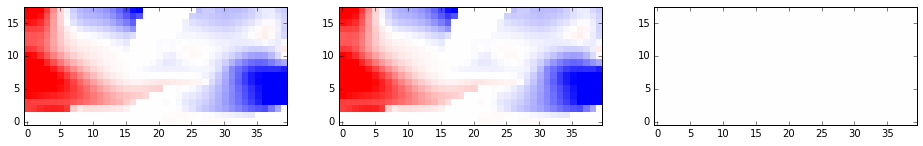

In [18]:
%matplotlib inline
#plt.style.use('dark_background')
f, ax = plt.subplots(1, 3, figsize=(16,6))
ax[0].imshow(detadt1[1:-1, 1:-1], origin='lower', interpolation='nearest', vmin = -1e-6, vmax = 1e-6, cmap='bwr')
ax[1].imshow(detadt[1:-1, 1:-1], origin='lower', interpolation='nearest', vmin = -1e-6, vmax = 1e-6, cmap='bwr')
ax[2].imshow(detadt1[1:-1, 1:-1]-detadt[1:-1, 1:-1], origin='lower', interpolation='nearest',\
             vmin = -1e-9, vmax = 1e-9, cmap='bwr')